Origin-destination matrix estimation

Possibly useful for constructing P matrix: probability of going through edges when moving from A to B

- https://openrouteservice.org/services/  (e.g. nearest)
- Google Maps API, maybe Google Distance Matrix API, maybe Google Geotagging API
- https://www.opentripplanner.org/ (Helps: https://github.com/jeromemayaud/OpenTripPlanner-OD-matrix)
Directions API: Directions between multiple locations, Distance Matrix API: Travel times and distances between locations<br>
Routes API: Performance optimized versions of the Directions and Distance Matrix APIs<br>
Roads API: Snap-to-road functionality to accurately trace GPS breadcrumbs.  maybe Places API

"QNEAT3 OD Matrix Calculation": https://github.com/kahlulz/Olongapo-City-Hospital-Network-Analysis<br>
Spatial Analysis: QGIS is utilized to conduct spatial analysis. Hospital locations were mapped, and distance-based calculations were performed using QNEAT3 OD Matrix Calculation. <br>
https://gis.stackexchange.com/questions/403556/what-unit-is-represented-by-od-matix-costs-in-qneat3-within-qgis-3-6-noosa?newreg=400dd6f344ab480a959ecfc8002019b9 <br>
https://root676.github.io/OdMatrixAlgs.html <br>
https://www.qgistutorials.com/en/docs/3/origin_destination_matrix.html

In [1]:
import map_functions
import computing_functions

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

gdf = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")

In [2]:
geo_positions = {
    "Budapest": (47.497912, 19.040235),
    "Kecskemét": (46.906770, 19.691383),
    "Szeged": (46.253000, 20.141424),
    "Szolnok": (47.172424, 20.178190),
    "Debrecen": (47.531605, 21.627312),
    "Nyíregyháza": (47.955879, 21.716837),
    "Miskolc": (48.104385, 20.791731),
    "Dunaújváros": (46.961511, 18.940582),
    "Szekszárd": (46.348886, 18.706048),
    "Pécs": (46.072734, 18.232266),
    "Székesfehérvár": (47.186644, 18.422595),
    "Siófok": (46.911703, 18.040138),
    "Győr": (47.687453, 17.634782),
    "Sopron": (47.686567, 16.588856),
    "Szombathely": (47.130884, 16.621046),
    "div_point_Miskolc_Debrecen": (47.7, 20.2),
    "div_point_Debrecen_Nyíregyháza": (47.6, 20.8),
    "div_point_Sopron_Szombathely": (47.4, 17.2),
    "Veszprém": (47.093658, 17.911332)
}

## P-matrix: paths with Google

Google returns only 3 opportunities, and it's hard to tell how they map to our system.

In [3]:
import json
key = json.loads(open('keys.json').read())[""]

KeyError: ''

In [ ]:
import googlemaps

gmaps = googlemaps.Client(key=key)
directions_result = gmaps.directions("Hegyeshalom", "Mosonszolnok", alternatives=True)
#Possible directions test
for i, route in enumerate(directions_result):
    print(f"Route {i+1}:")
    for step in route['legs'][0]['steps']:  
        print(step['html_instructions'])
    print("\n\n")

Route 1:
Head <b>southwest</b> on <b>Alkotmány u.</b>
Turn <b>left</b>
Turn <b>right</b> at <b>Orgona u.</b>
Turn <b>right</b>
Turn <b>left</b>
Continue onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route 2:
Head <b>northeast</b> on <b>Alkotmány u.</b> toward <b>Damjanich u.</b>
Turn <b>right</b> onto <b>Damjanich u.</b>
Turn <b>left</b> onto <b>Szolnoki u.</b>
Continue onto <b>Kertalja u.</b>
Turn <b>right</b> onto <b>Fő u.</b>/<wbr/><b>Route 1</b><div style="font-size:0.9em">Continue to follow Route 1</div>
At the roundabout, take the <b>3rd</b> exit and stay on <b>Route 1</b>
At the roundabout, take the <b>2nd</b> exit and stay on <b>Route 1</b>
Turn <b>right</b> onto <b>Szolnoki út</b>
Continue onto <b>Óvári u.</b>
Continue onto <b>Fő u.</b>
Turn <b>left</b> onto <b>Szabadság út</b>
Turn <b>right</b> onto <b>Jókai u.</b><div style="font-size:0.9em">Destination will be on the right</div>



Route

## P-matrix for a small case: computing based on shortest paths

(give back all shortest paths, and 1/n on each path (+multiplicalities), 0 elsewhere..)

In [3]:
import pickle
with open("networks/Hungary_major_connections_upgraded_no_IDs.gpickle", "rb") as f:
    G_simple = pickle.load(f)

In [4]:
pos = {city: (lon, lat) for city, (lat, lon) in geo_positions.items()}#Just converting to dict (map) format for networkx

#Rename node names for better visualization
node_names = {city: city for city in pos.keys()}
node_names['div_point_Miskolc_Debrecen'] = 'd_M_D'
node_names['div_point_Debrecen_Nyíregyháza'] = 'd_D_Ny'
node_names['div_point_Sopron_Szombathely'] = 'd_S_Sz'

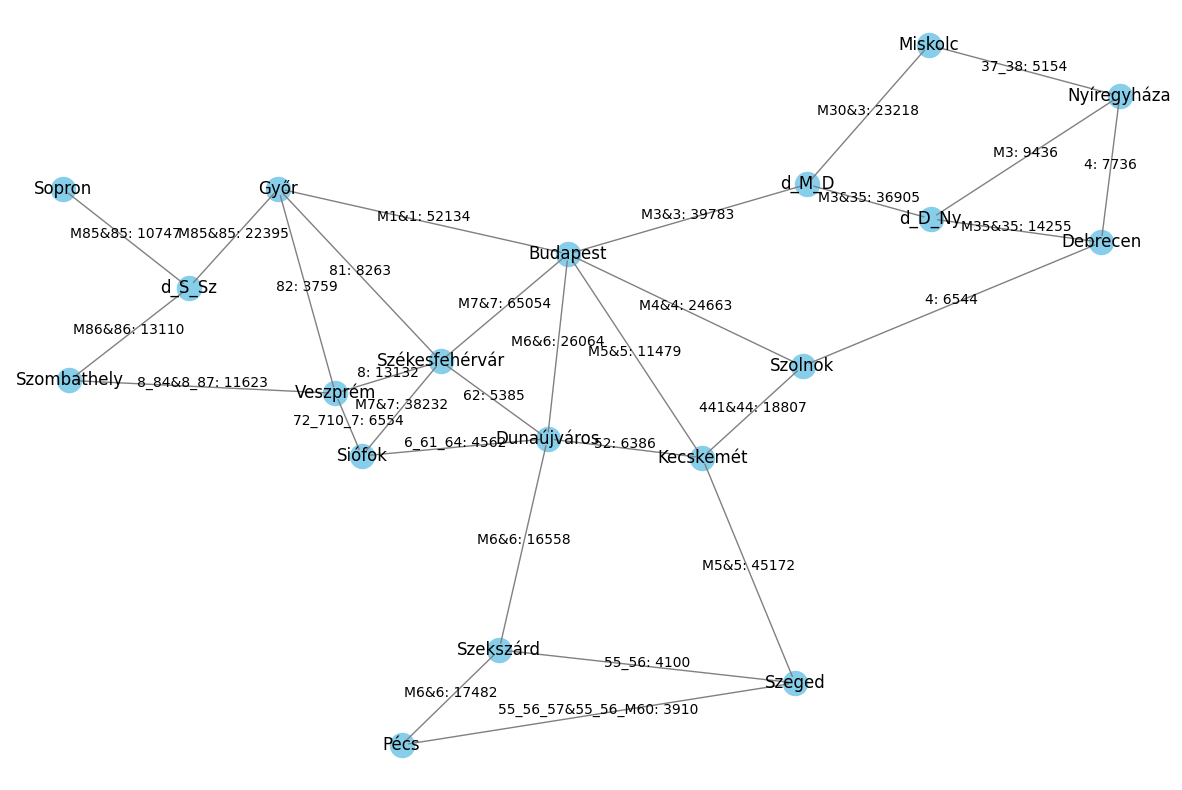

In [5]:
map_functions.plot_map_simple_graph(G_simple, pos, node_names)

E.g. shortest paths:

In [6]:
roads = list(G_simple.edges())
road_traffics = [G_simple.get_edge_data(road[0], road[1])['weight'] for road in roads]

locations = list(G_simple.nodes())
#locations.remove('div_point_Miskolc_Debrecen'); locations.remove('div_point_Debrecen_Nyíregyháza'); locations.remove('div_point_Sopron_Szombathely')
shortest_paths_dict = {}
for i in range(len(locations)):
    source = locations[i]
    for j in range(i+1,len(locations)):
        target = locations[j]
        if source != target:
            paths = nx.all_shortest_paths(G_simple, source=source, target=target)
            shortest_paths_dict[(source, target)] = list(paths)

In [7]:
extra_paths = computing_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']
v, P, odm, extra = computing_functions.v_P_odmbp_shortest_paths(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)
v_reduced, P_reduced, odm_reduced, extra_reduced = computing_functions.v_P_odmbp_reduced_matrix(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)

Something is still not perfect:

In [8]:
np.linalg.matrix_rank(P_reduced), P_reduced.shape, v_reduced.shape

(29, (30, 120), (30,))

Seems that there is something wrong with simpy (possibly the issue comes from digits accuracy).

When finding that there is some linear dependency in a group of many rows/vectors, you have to kind of backtrack to see which vectors are inherently needed for the linear independency. In a group which contains some vectors linearly dependent, you have to go check each element whether they are part of causing the linear dependency. If for a group A, the rank is rank(A)=n, you can check whether an element (row vector) causes the linear dependency by checking if the rank changes when removing that element: if the rank decreases, they are linearly independent from other vectors, not part of the group. The group will only consist of elements which when removed, do not change the rank.

In [33]:
computing_functions.find_minimal_dependent_rows(P_reduced)

[[2, 10, 11]]

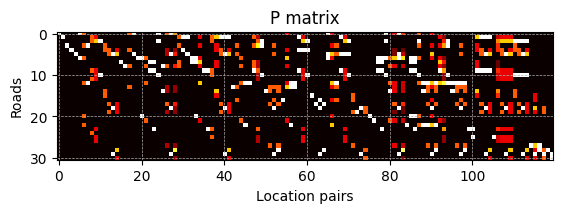

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.imshow(P, cmap='hot', interpolation='nearest')
#fig.colorbar(cax)
ax.set_title('P matrix')
ax.set_xlabel('Location pairs')
ax.set_ylabel('Roads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
from scipy.io import savemat

#Save the P matrix in a .mat file
savemat('computing/P_matrix_16_cities.mat', {'P': P})
np.savetxt("computing/P_matrix_16_cities.csv", P, delimiter=",", fmt='%.3f')
np.savetxt("computing/P_matrix_reduced_16_cities.csv", P_reduced, delimiter=",", fmt='%.3f')

## Constrainted optimization

... is using a non-linear constraint, which is slow, because the optimizer must evaluate the constraint everywhere. `scipy.optimize.LinearConstraint` is faster, because it can quickly find the subspace where the constraint is satisfied. It'd be faster by rewriting it as `LinearConstraint(P, ub=v, lb=v)`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.LinearConstraint.html

Another speed tip is to give it an explicit gradient with `minimize(..., jac=fprime)` argument, `def fprime(x): return np.log(x) + 1`. This will save N function evaluations per iteration versus doing it numerically, where N is the number of dimensions of your problem, so it's helpful with high dimensions

A way to attack the singularity problem from another direction is method='trust-constr'. It seems to have an optimization algorithm which can cope with constraints being singular. This solver is often more reliable than SLSQP, but it's also slower

### Entropy maximization

In [11]:
from scipy.optimize import minimize, Bounds, LinearConstraint

#Objective function
def entropy_max(odm):
    #Entropy maximizing (== minimizing the negative entropy)
    return np.sum(odm * np.log(odm))

def entropy_max_derivative(x): 
    return np.log(x) + 1

#Constraint(s)
def constraint_eq_reduced(odm):
    return P_reduced @ odm - v_reduced
#def constraint_eq(odm):
#    return P @ odm - v
#constraints = {'type': 'eq', 'fun': constraint_eq}

constraints_reduced = {'type': 'eq', 'fun': constraint_eq_reduced}
bounds = Bounds(0.001, 100000) #np.inf
result = minimize(entropy_max, odm_reduced, constraints=constraints_reduced, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [12]:
print('Success:', result.success)
print('Message:', result.message)

Success: False
Message: Iteration limit reached


In [13]:
optimal_odm_copy = optimal_odm.copy()

In [14]:
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=constraints_reduced, bounds=bounds)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)

Message: More than 3*n iterations in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem
Message: Singular matrix C in LSQ subproblem


I believe the singularity may have came from either sub-optimal ODM values, or ODM values that cause trouble when used as initial values.

In [15]:
import pandas as pd

df1 = pd.DataFrame({
    'location_pair': extra_reduced['location_pairs'],
    'ODM_value': optimal_odm_copy
})
df2 = pd.DataFrame({
    'location_pair': extra_reduced['location_pairs'],
    'ODM_value': optimal_odm_list[0]
})
df3 = pd.DataFrame({
    'location_pair': extra_reduced['location_pairs'],
    'ODM_value': optimal_odm_list[1]
})

df1.to_csv('computing/odm/ODM_16_cities_1.csv', index=False)
df2.to_csv('computing/odm/ODM_16_cities_2.csv', index=False)
df3.to_csv('computing/odm/ODM_16_cities_3.csv', index=False)

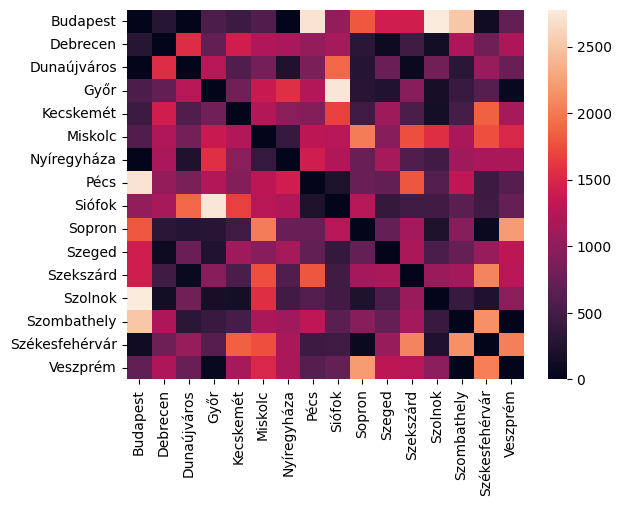

In [19]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm_copy, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

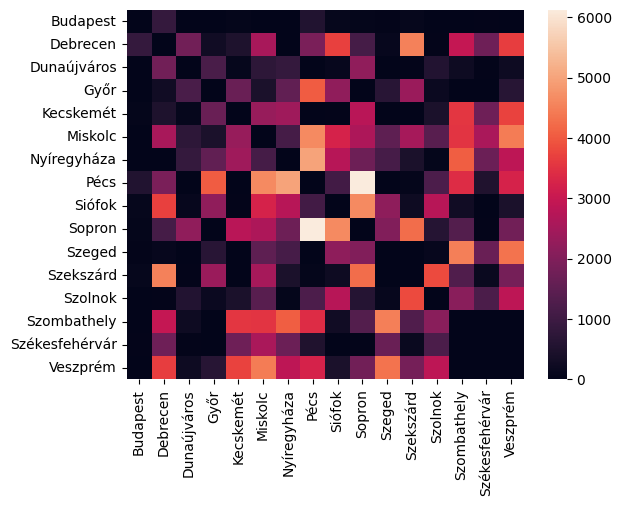

In [20]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm_list[1], location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

Looking into it, entropy maximization doesn't really seem like a good method.. it puts too much weight on far distances.

### Entropy minimization

In [21]:
def entropy_min(odm):
    return -np.sum(odm * np.log(odm))

result = minimize(entropy_min, odm_reduced, constraints=constraints_reduced, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [22]:
print('Success:', result.success)
print('Message:', result.message)

Success: False
Message: Positive directional derivative for linesearch


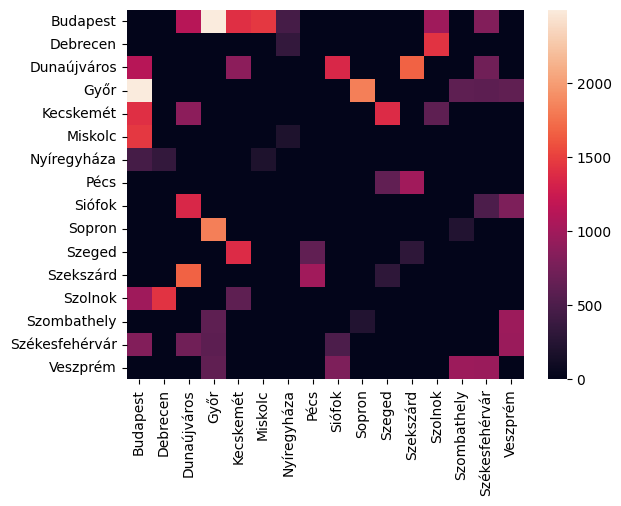

In [24]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

### Linear constraint

In [25]:
lin_constraint = LinearConstraint(P_reduced, lb=v_reduced, ub=v_reduced)
result = minimize(entropy_max, odm_reduced, constraints=lin_constraint, bounds=bounds) #jac=entropy_derivative

In [26]:
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)

Success: False
Message: Iteration limit reached


In [27]:
optimal_odm_copy = optimal_odm.copy()

In [28]:
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=lin_constraint, bounds=bounds)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)

Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible
Message: Inequality constraints incompatible


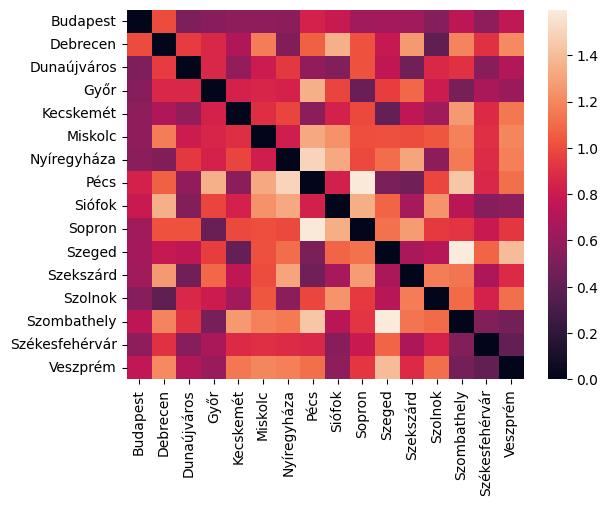

In [31]:
odm_2d,odm_locations = computing_functions.get_odm_2d_symmetric(odm = optimal_odm, location_pairs=extra_reduced['location_pairs'])
computing_functions.plot_odm(odm_2d, odm_locations)

We need to first fix the P_reducing function, we need to really reduce P to have linearly independent rows. 